## This notebook explores different definitions of a scope score to quantitatively compare scopes.

In notebook 1 (1_Overall_Trends_and_Notes), we saw that changing hyperparameter settings of the scope algorithm leads to opposite trends for the average objective value (which is the rate in the ArI dataset) as a performance metric and the Vendi score as a diversity metric. To find an optimal scope, a tradeoff point needs to be found.

In order to optimize the algorithm, a quantitative metric for scope comparison is needed. We envisioned that such a metric, which we call scope score, could be defined by one of the following equations:

Average: [scope score] = ([average objective] + [Vendi score]) / 2

Product: [scope score] = [average objective] * [Vendi score]

Geometric mean: [scope score] = SQRT([average objective] * [Vendi score])

To ensure an equal weight of both components of the scope score, they need to be scaled. The selected normalization as the scaling function as it scaled both components to a [0,1]-scale. This notebook will evaluate the different scope score definitions as well as normalization bounds.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
from Code.utils import obtain_full_covar_matrix, calculate_vendi_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import stdev
import os
import shutil
import ast
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

## Dataset definition

As a dataset, we will use the full ArI dataset with added noise (high level; see Notebook "3_Noise_Dependence"). As in the other notebooks in this folder, we will use a scope size of 30 samples.

## Running scopes with different acquisition functions

To get insights into what average rates and Vendi scores can be obtained using this dataset, scopes with different settings and acquisition functions were run: balanced (which refers to Expected Improvement), greedy, explorative, random.

We ran scopes in steps of 10% Vendi pruning per batch. As 10% pruning already leads to a large amount of pruning overall (e. g. batch size 4 --> 8 batches for a scope of 30 samples --> 7 rounds of pruning (no pruning in initiation round) --> 0.9**7 = 48% of search space remaining at end of the scope), we also added 3% and 6% pruning to also collect data for intermediate overall pruning (81% or 65% of samples remaining with the same settings, respectively).

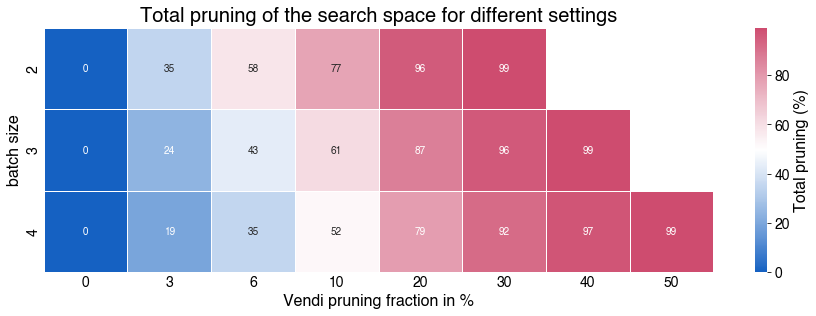

In [2]:
# approximate the total amount of pruning for a given combination of batch size and pruning % (per round)
total_pruning = pd.DataFrame(np.nan,index=[2,3,4],columns=[0,3,6,10,20,30,40,50])
for percentage in total_pruning.columns:
    for batch in total_pruning.index:
        if (batch == 2 and percentage < 40) or (batch == 3 and percentage < 50) or batch == 4:  # limit to feasible combinations of the full combinatorial
            pruning = 1 - (1 - percentage/100)**(np.ceil(30/batch) -1)  # minus 1 in exponent because the pruning only starts in the second round
            total_pruning.loc[batch,percentage] = round(pruning*100,2)
plt.figure(figsize=(15,4.5))
heatmap = sns.heatmap(total_pruning, annot=True, linewidths=1,cmap='Doyle_cont',cbar_kws={'label': "Total pruning (%)"})
heatmap.set(xlabel="Vendi pruning fraction in %", ylabel="batch size")
heatmap.tick_params(length=0)
plt.title("Total pruning of the search space for different settings")
plt.show()


In [3]:
# acqfct = ["balanced","greedy","explorative","random"]
# for acq in acqfct:
#     batch_pruning_combinations = {2: [0,3,6,10,20,30], 3: [0,3,6,10,20,30,40], 4: [0,3,6,10,20,30,40,50]}
#     for batch in batch_pruning_combinations.keys():
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",  
#             name_results = f"./Results_Data/Scope_Score_Definition/30{acq}/30{acq}_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= acq,
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random")

Look at the results

In [4]:
def generate_heatmap_summary(acq,results_folder, budget, report_types=["vendi","objective"]):

    wdir = Path(".")
    df_list_vendi = []
    df_list_obj = []

    for batch in [2,3,4]:
        dfs = {}
        for info_type in ["vendi","obj[rate]"]:
            csv_filename_results = wdir.joinpath(f"./{results_folder}/30{acq}_b{batch}/benchmark_{info_type}_av.csv")
            dfs[info_type] = pd.read_csv(csv_filename_results,index_col=0,header=0, float_precision = "round_trip")
            dfs[info_type] = dfs[info_type].applymap(lambda x: ast.literal_eval(x))
            if info_type == "vendi": # contains the Vendi scores for each round in each element
                dfs[info_type] = dfs[info_type].applymap(lambda x: x[-1])  # only keep the final Vendi score
            else: # contains the average objective values for each round in each element
                for batch in list(dfs[info_type].index):
                    if budget % batch == 0:  
                        dfs[info_type].loc[batch] = dfs[info_type].loc[batch].apply(lambda x: sum(x)/len(x))  # get the overall objective value average
                    else:
                        # calculate the average yield while considering that the size of the last batch in the run was smaller
                        dfs[info_type].loc[batch] = dfs[info_type].loc [batch].apply(lambda x: (sum(x[:-1])*batch+x[-1]*(budget % batch))/budget)
            dfs[info_type] = dfs[info_type].apply(pd.to_numeric)

        df_list_vendi.append(dfs["vendi"])
        df_list_obj.append(dfs["obj[rate]"])

    df_combined_vendi = pd.concat(df_list_vendi)
    df_combined_obj = pd.concat(df_list_obj)

    def create_plot(data,label):
        plt.figure(figsize=(7,4.5))
        heatmap = sns.heatmap(data,annot=True, fmt=".3f", linewidths=1,cmap='Doyle_cont',cbar_kws={'label': label.split("(")[0]})
        heatmap.set(xlabel="Vendi pruning fraction in %", ylabel="batch size")
        heatmap.tick_params(length=0)
        plt.title(label)
        plt.show()

    if "objective" in report_types:
        create_plot(df_combined_obj,f"Average rate ({acq} acquisition)")

    if "vendi" in report_types:
        create_plot(df_combined_vendi,f"Vendi score ({acq} acquisition)")

    return df_combined_vendi, df_combined_obj

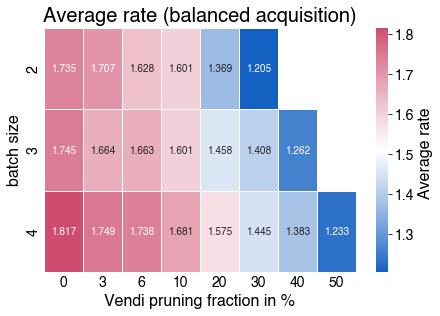

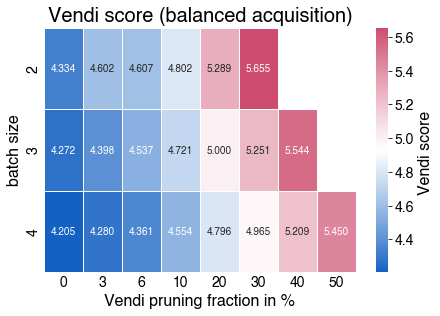

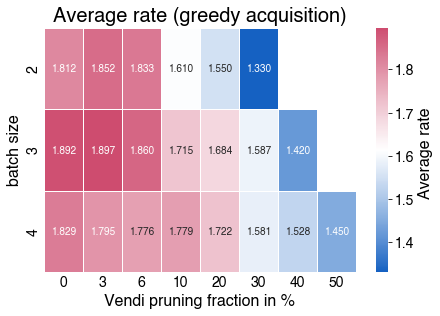

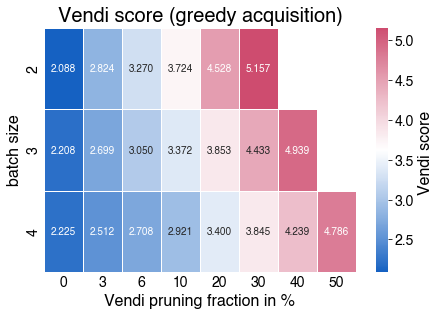

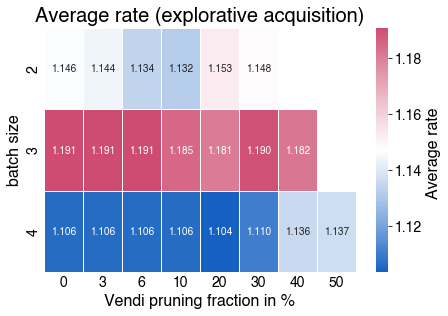

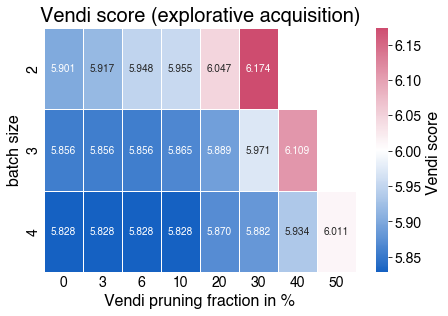

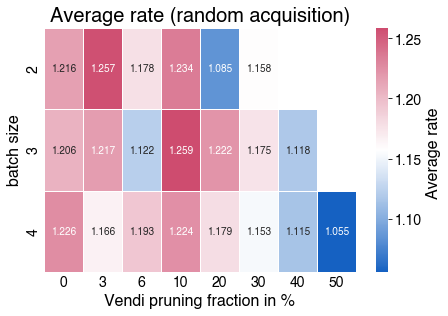

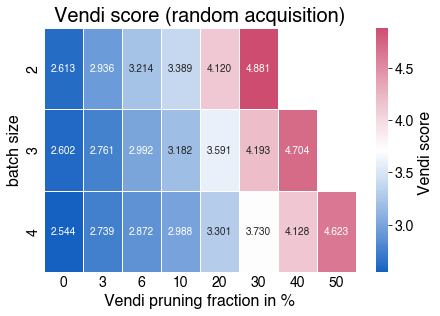

In [5]:
dfs_obj = {}
dfs_vendi = {}
acqfct = ["balanced","greedy","explorative","random"]
for acq in acqfct:
    dfs_vendi[acq], dfs_obj[acq] = generate_heatmap_summary(acq=acq,results_folder=f"./Results_Data/Scope_Score_Definition/30{acq}", budget=30)

High average rates are only obtained using the balanced or greedy acquisition function whereas the greedy acqusition function provides the highest average rates.

The explorative acquisition function provides the highest Vendi scores, but other acquisition functions also strongly increase their Vendi scores with increasing pruning.

## Obtaining the bounds

### Bounds by repeated random sampling

To get the distribution of the average objectives and Vendi scores, we can monitor their values of many randomly selected scopes. The extreme values obtained by this means could be used as the bounds for the normalization scaling.

In [6]:
# read in the labelled dataset and get the covariance matrix of the surrogate model
df_labelled = pd.read_csv(wdir.joinpath("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv"),index_col=0,header=0)
full_covar_matrix = obtain_full_covar_matrix(objectives=["rate"],directory=".", 
                                             filename="./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv")

In [7]:
# Creating 1,000,000 randomly selected scopes and recording their metrics
vendi_scores = []
obj_scores = []
for seed in tqdm(range(1000000),leave=False):
    df_subset = df_labelled.sample(n=30, random_state=seed)  # randomly select a scope
    current_obj = df_subset["rate"].mean()
    idx_selected = [df_labelled.index.get_loc(idx) for idx in df_subset.index]
    current_vendi = calculate_vendi_score(idx_num=idx_selected, covariance_matrix=full_covar_matrix) # calculate the Vendi score
    vendi_scores.append(current_vendi)
    obj_scores.append(current_obj)

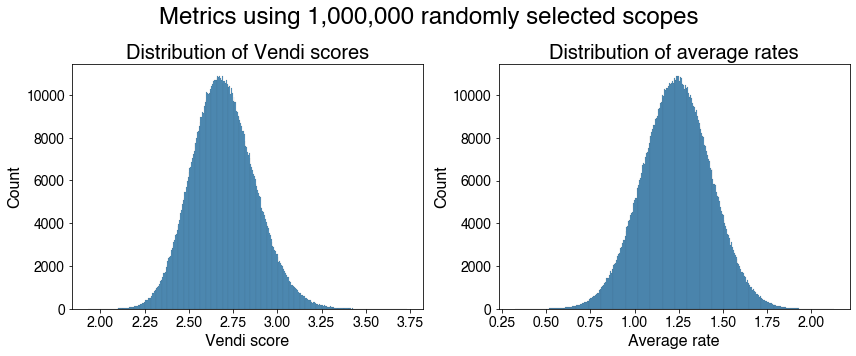

Summary of characteristic metric values of the 1,000,000 randomly selected scopes:


Max   Mean    Min  Std. Dev.
Score                                            
average objective  2.129  1.239  0.319      0.195
Vendi score        3.732  2.697  1.930      0.179

In [8]:
# Plot the results of these 1,000,000 scopes
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
fig.suptitle("Metrics using 1,000,000 randomly selected scopes")
sns.histplot(ax=axes[0], data=vendi_scores).set(xlabel="Vendi score")
axes[0].set_title("Distribution of Vendi scores")
sns.histplot(ax=axes[1], data=obj_scores).set(xlabel="Average rate")
axes[1].set_title("Distribution of average rates")
plt.tight_layout()
plt.show()

print("Summary of characteristic metric values of the 1,000,000 randomly selected scopes:")
df_random_sampling = pd.DataFrame({"Score": ["average objective","Vendi score"],
                            "Max":[max(obj_scores),max(vendi_scores)],
                            "Mean":[np.mean(obj_scores),np.mean(vendi_scores)],
                            "Min":[min(obj_scores),min(vendi_scores)],
                            "Std. Dev.": [stdev(obj_scores),stdev(vendi_scores)]})
df_random_sampling.set_index(keys="Score",inplace=True)
df_sampling_rounded = df_random_sampling.copy(deep=True)
df_sampling_rounded[["Max","Min","Mean","Std. Dev."]] = df_sampling_rounded[["Max","Min","Mean","Std. Dev."]].apply(lambda x: round(x,3))
df_sampling_rounded

The maximum Vendi score obtained by the repeated sampling is much smaller than the values obtained in the screening of different acquisition functions (e. g., explorative acq. gives up to 6.174). Thus, the random sampling is not effective at providing global extreme values that could be used for normalization despite the large number of random selections.

## Bounds by targeting of extreme values

For the rates, we can calculate the highest and lowest averages that are possible with the dataset since we know all the labels.

In [9]:
# calculation of the best and worst scope in terms of rate (top-/ worst-30 rates in the dataset)
df_rates = df_labelled.loc[:,"rate"].sort_values()
top_average = np.mean(df_rates[-30:])
worst_average = np.mean(df_rates[:30])
print(f"Best possible rate average in a scope: {round(top_average,3)}")
print(f"Worst possible rate average in a scope: {round(worst_average,3)}")

Best possible rate average in a scope: 4.004
Worst possible rate average in a scope: -1.586


To get a minimum Vendi score, we need to select compounds that are highly similar. This can be achieved by running a scope that it selected by lowest variance of the samples as the variance will be the smallest next to previously selected samples.

In [10]:
# # Run the scopes
# Benchmark().collect_data(
#     filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",  
#     name_results = f"./Results_Data/Scope_Score_Definition/30low_variance", objectives=['rate'], 
#     budget = 30, batches= [1,2,3,4], Vendi_pruning_fractions = [0], seeds = 20, acquisition_function_mode= "low_variance",
#     pruning_metric= "vendi_batch", init_sampling_method="random")

In [11]:
# Get the data
df_low_variance = Benchmark().heatmap_plot(type_results="vendi",name_results="./Results_Data/Scope_Score_Definition/30low_variance",
                                           budget=30,show_plot=False)
vendi_low_variance = df_low_variance.min().min()  # recording the lowest Vendi score
print(f"The lowest Vendi score obtained with the low variance acquisition function is {round(vendi_low_variance,3)}.")

The lowest Vendi score obtained with the low variance acquisition function is 1.276.


The highest Vendi score so far was obtained with the explorative acquisition function (see above). Let's try to improve this value by running scopes with th explorative acquisition function and the highest possible pruning settings that the reaction space allows.

In [12]:
# # most extreme vendi pruning for a reaction space of 2055 and scope of 30 samples for the different batch sizes
# extreme_pruning = {1: 17, 2: 33, 3: 46, 4: 57}
# # Run the scopes
# for batch in extreme_pruning:
#     Benchmark().collect_data(
#         filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",  
#         name_results = f"./Results_Data/Scope_Score_Definition/30explorative_max/30explorative_max_b{batch}", objectives=['rate'], 
#         budget = 30, batches= [batch], Vendi_pruning_fractions = [extreme_pruning[batch]], seeds = 20, 
#         acquisition_function_mode= "explorative", pruning_metric= "vendi_batch", init_sampling_method="random")

In [13]:
# Get the data
vendi_explore_max = []
for batch in [1,2,3,4]:
    df_explore_max = Benchmark().heatmap_plot(type_results="vendi",
                                              name_results=f"./Results_Data/Scope_Score_Definition/30explorative_max/30explorative_max_b{batch}",
                                              budget=30,show_plot=False)
    vendi_explore_max.append(df_explore_max.max().max())  # recording the highest Vendi score for this scope
vendi_explorative = max(vendi_explore_max)
print(f"The highest Vendi score obtained with the explorative acquisition function is {round(vendi_explorative,3)}.")

The highest Vendi score obtained with the explorative acquisition function is 6.22.


In [14]:
def gen_scope_score_dist(vendi_bounds,obj_bounds,acq_fct,only_prod=False, figsize=(20,5)):
    """
    Generates a scope score heatmap plot.
    vendi_bounds, obj_bounds: tuple of the bounds for the respective metric
    acq_fct: str for the acquisition function name
    """
    dfs_scope_scores = {}
    score_def = ["average","product","geometric_mean"]
    if only_prod:
        score_def = ["product"]
    for scope_method in score_def:
        dfs = []
        for batch in [2,3,4]:
            results_folder = f"./Results_Data/Scope_Score_Definition/30{acq_fct}/30{acq_fct}_b{batch}"
            dfs.append(Benchmark().heatmap_plot(type_results="scope",name_results=results_folder,budget=30,
                                                show_plot=False,scope_method=scope_method,bounds={"rate":obj_bounds,"vendi":vendi_bounds}))
        dfs_scope_scores[scope_method] = pd.concat(dfs,axis=0)
    fig, axes = plt.subplots(1,len(score_def),figsize=figsize,gridspec_kw={"wspace": 0.1},constrained_layout=True,dpi=600)
    fig.suptitle(f"Scope scores using the {acq_fct} acquisition function",fontsize=20)
    for i,definition in enumerate(dfs_scope_scores.keys()):
        if only_prod:
            axes = [axes]
        heatmap = sns.heatmap(ax=axes[i],data=dfs_scope_scores[definition],cmap="Doyle_cont",linewidths=1,annot=True,fmt=".3f",cbar_kws={"label":"Scope score"})
        axes[i].set_xlabel("Vendi pruning fraction in %")
        axes[i].set_ylabel("Batch size")
        axes[i].set_title(f"Defined as {definition}",fontsize=18)
        heatmap.tick_params(length=0)
    plt.show()

Using the global extrema

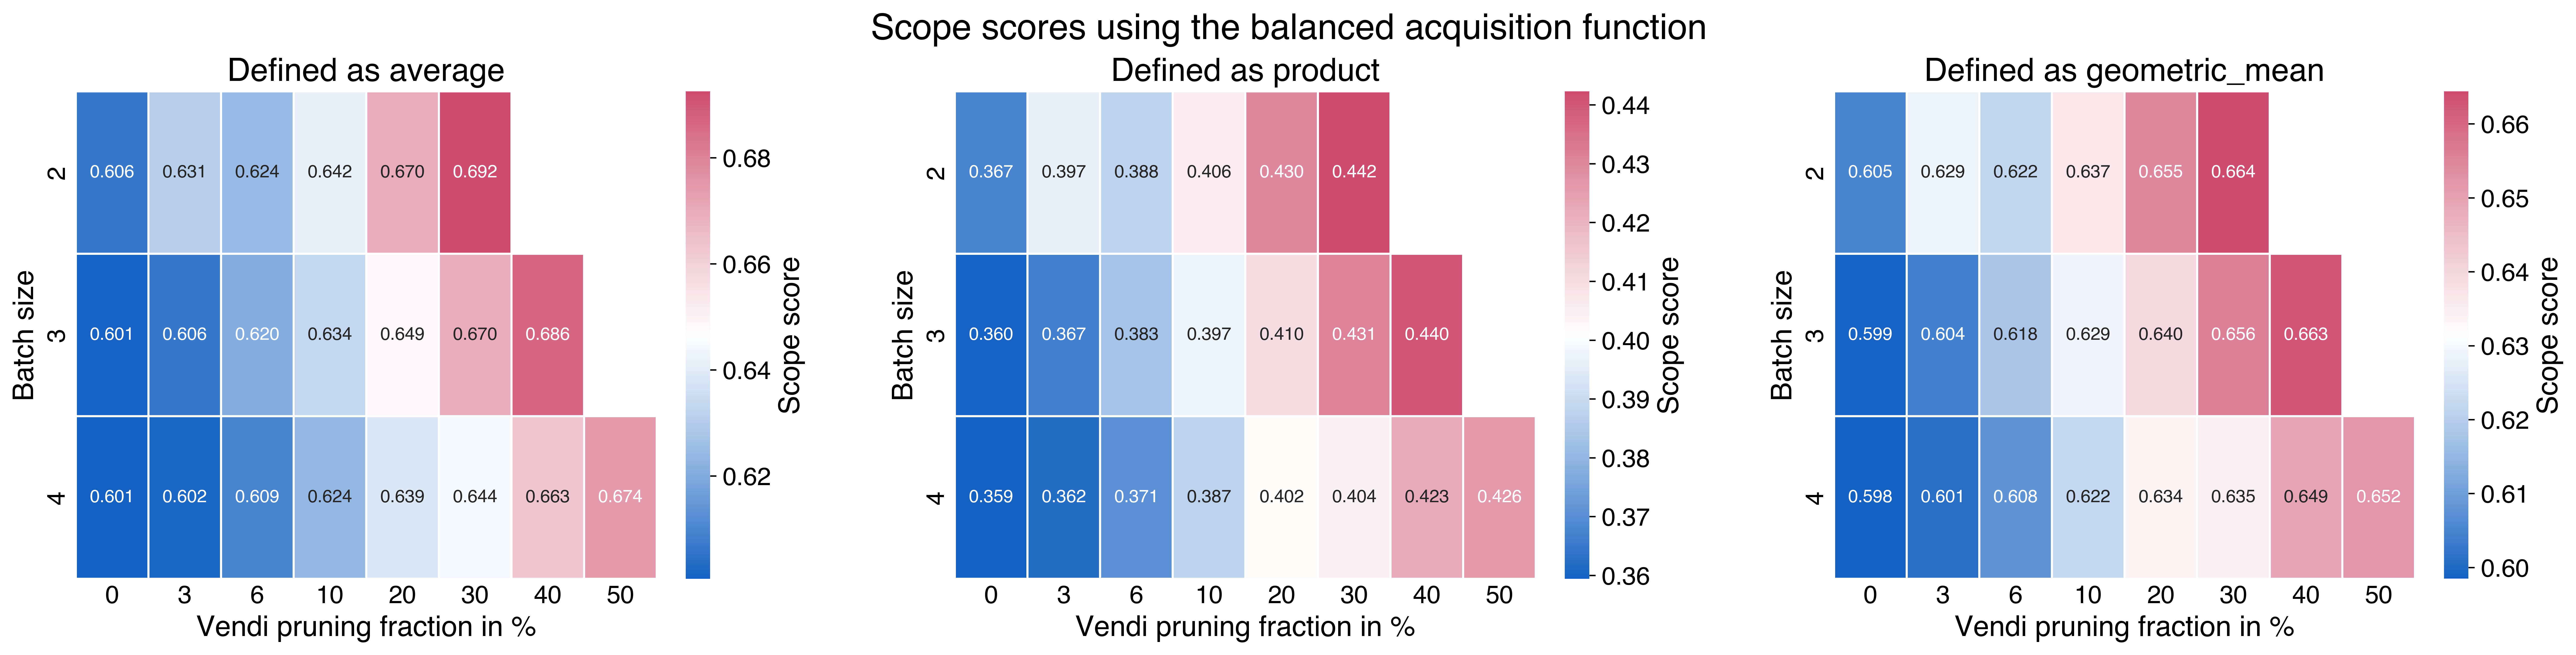

In [15]:
# using the most extreme values that were observed
gen_scope_score_dist(vendi_bounds=(vendi_explorative,vendi_low_variance),obj_bounds=(top_average,worst_average),acq_fct="balanced")

The scope score follow the same trend as the Vendi scores (see above). This way of calculating the scope score is therefore imbalanced towards the Vendi scores.

As the upper bounds that was used for the Vendi scores is the highest observed value for a Bayesian optimization campaign, we can also change the upper bounds for the average objectives to the corresponding value.

The highest average objective that was observed was generated by using the greedy acquisition function.

Now using the largest average rate observed with the greedy acquisition function as the upper bounds: 1.8969198867509403


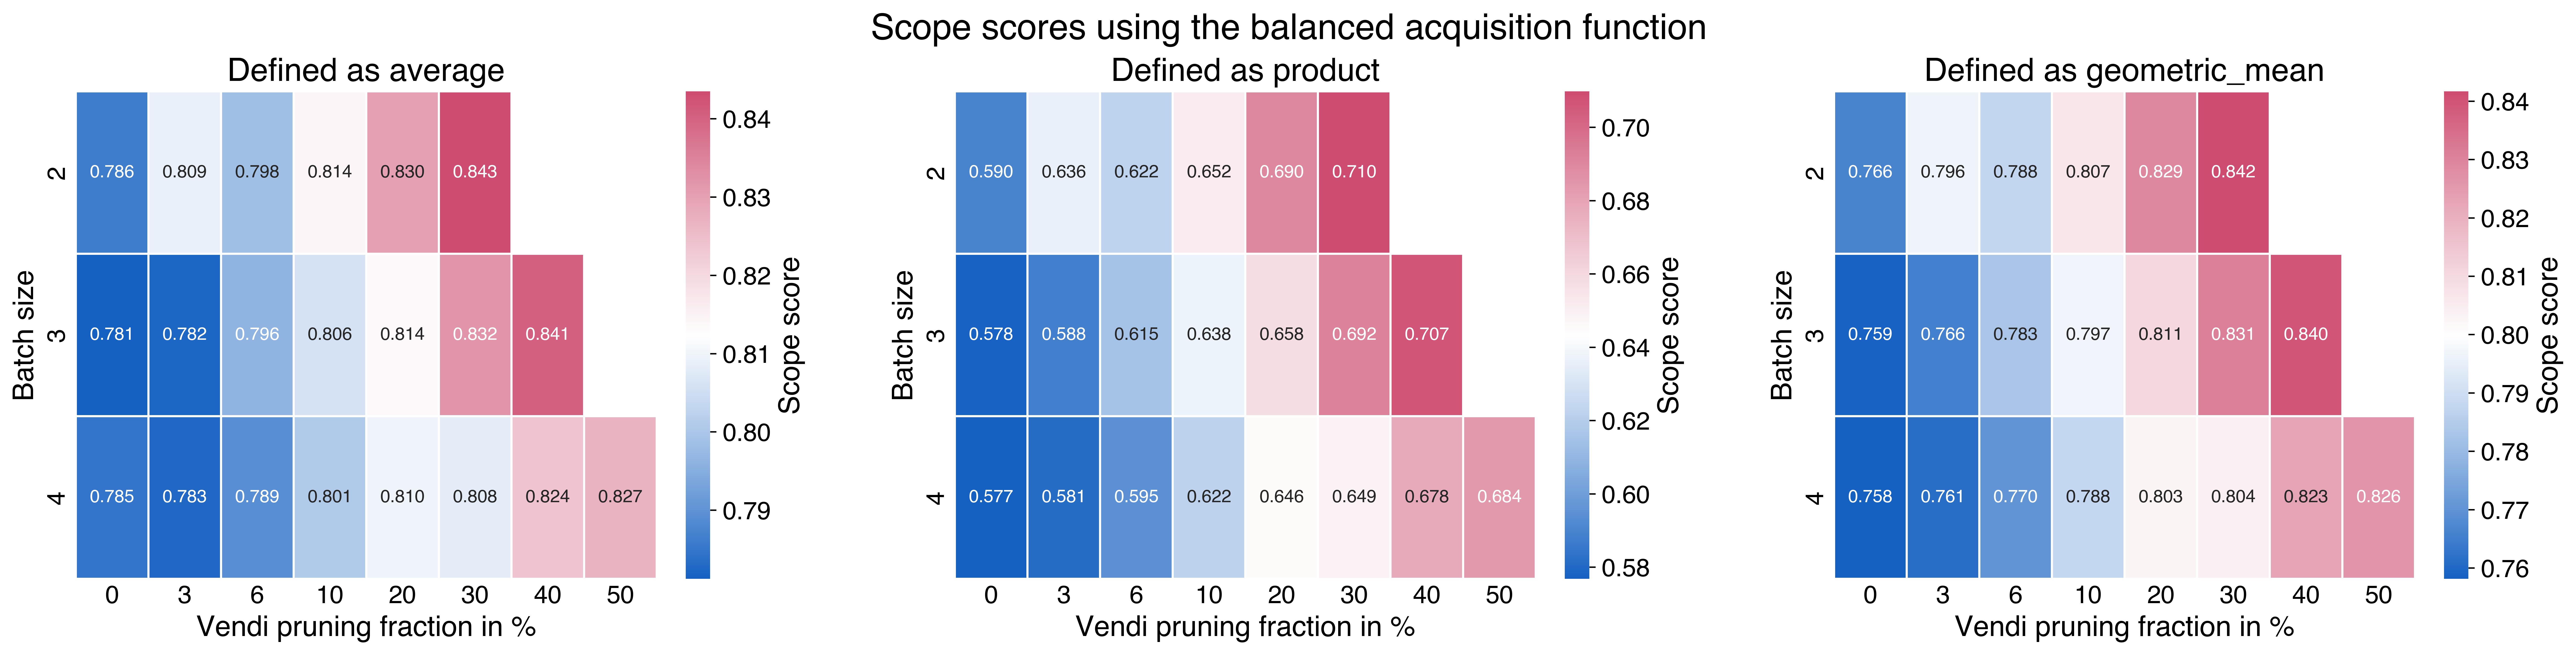

In [16]:
# using the best result of Bayesian Optimization as the maximum for the average objective (as already done for the Vendi scores)
obj_greedy = dfs_obj["greedy"].max().max()
print(f"Now using the largest average rate observed with the greedy acquisition function as the upper bounds:", obj_greedy)
gen_scope_score_dist(vendi_bounds=(vendi_explorative,vendi_low_variance),obj_bounds=(obj_greedy,worst_average),acq_fct="balanced")

This definition of the bounds also leads to imbalance of the scope scores towards the Vendi scores.

As for the upper bounds, we can also change the lower bounds to be the most extreme values that were obtained by Bayesian optimization.

Bounds used in the following graphs:
Lower bounds for Vendi score: 2.088 (obtained with the greedy acq. fct. (no pruning))
Upper bounds for Vendi score: 6.22 (obtained with the explorative acq. fct. (maximum pruning))
Lower bounds for average rate: 1.104 (obtained with the explorative acq. fct. (maximum pruning))
Upper bounds for average rate: 1.897 (obtained with the greedy acq. fct. (no pruning))


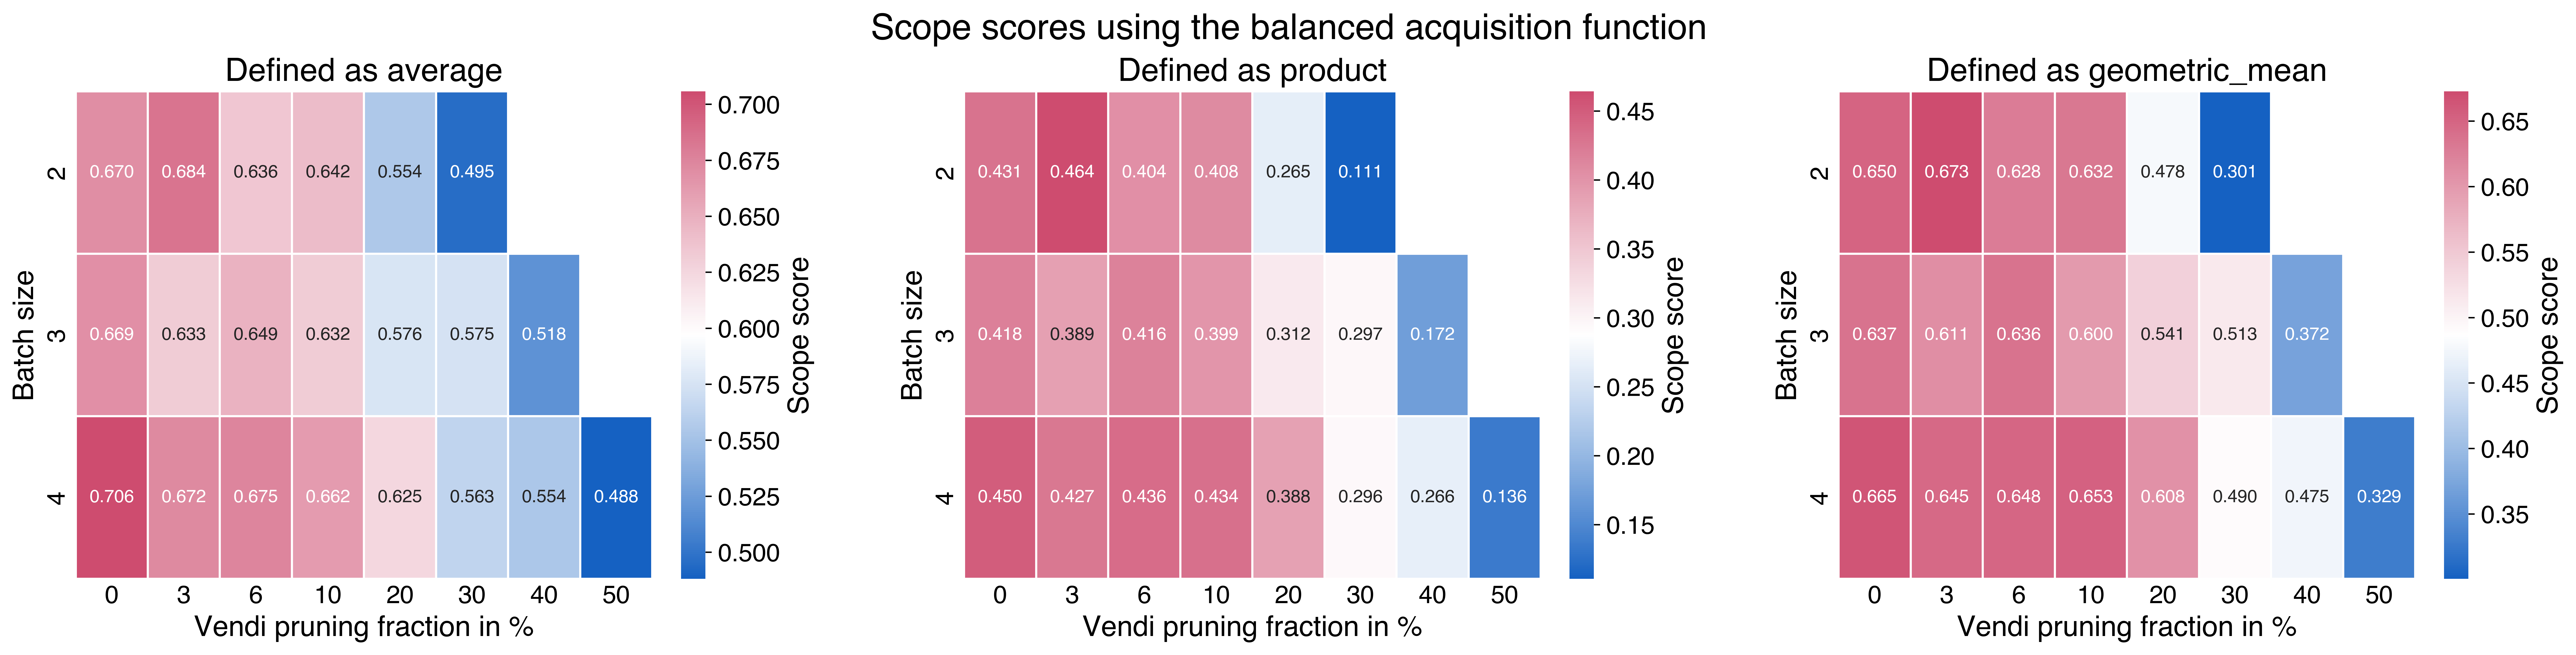

In [17]:
# using the best and worst values for average objective and Vendi score that were observed with 
# Bayesian optimization (using standard acq. fct. on the explore-exploit spectrum)
obj_min = dfs_obj["explorative"].min().min()
obj_max = obj_greedy
vendi_min = dfs_vendi["greedy"].min().min()
vendi_max = vendi_explorative
print("Bounds used in the following graphs:")
print(f"Lower bounds for Vendi score: {round(vendi_min,3)} (obtained with the greedy acq. fct. (no pruning))")
print(f"Upper bounds for Vendi score: {round(vendi_max,3)} (obtained with the explorative acq. fct. (maximum pruning))")
print(f"Lower bounds for average rate: {round(obj_min,3)} (obtained with the explorative acq. fct. (maximum pruning))")
print(f"Upper bounds for average rate: {round(obj_max,3)} (obtained with the greedy acq. fct. (no pruning))")
gen_scope_score_dist(vendi_bounds=(vendi_max,vendi_min),obj_bounds=(obj_max,obj_min),acq_fct="balanced")

This definition yields the best relative performance of scope scores at intermediate levels of Vendi pruning and therefore the best tradeoff in the scope scores between performance and diversity. We therefore selected to use this definition moving forward.

We can then also see how the scope scores look for the other acquisition functions.

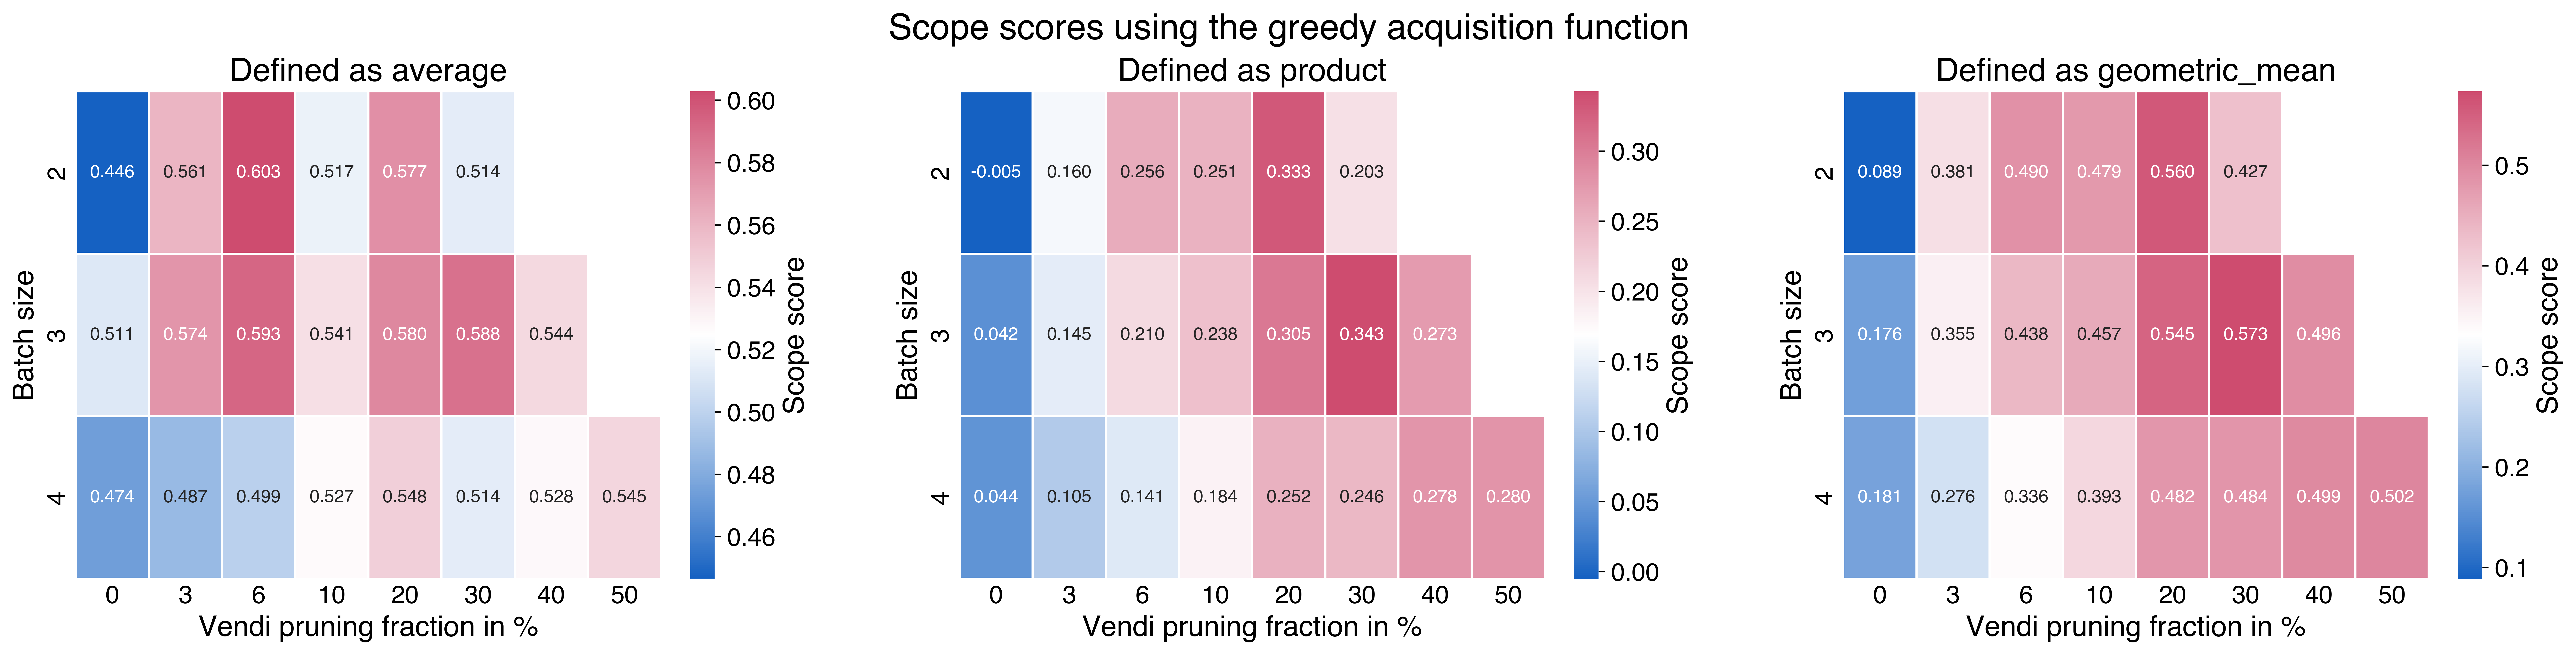

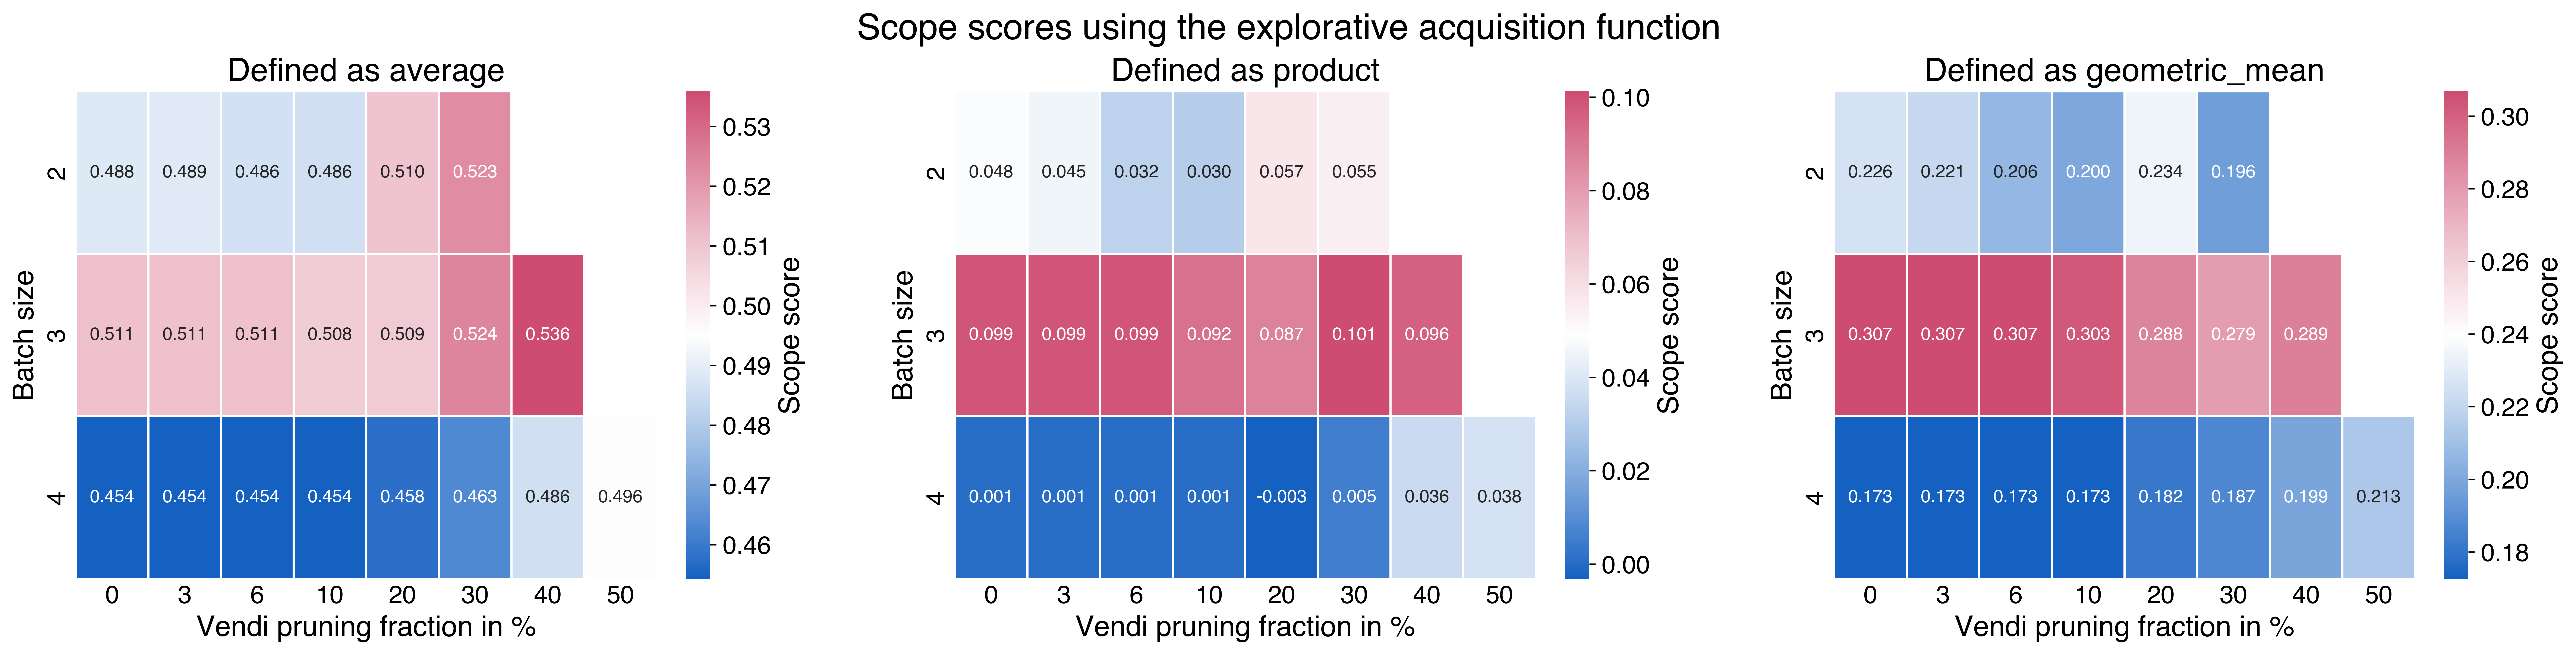

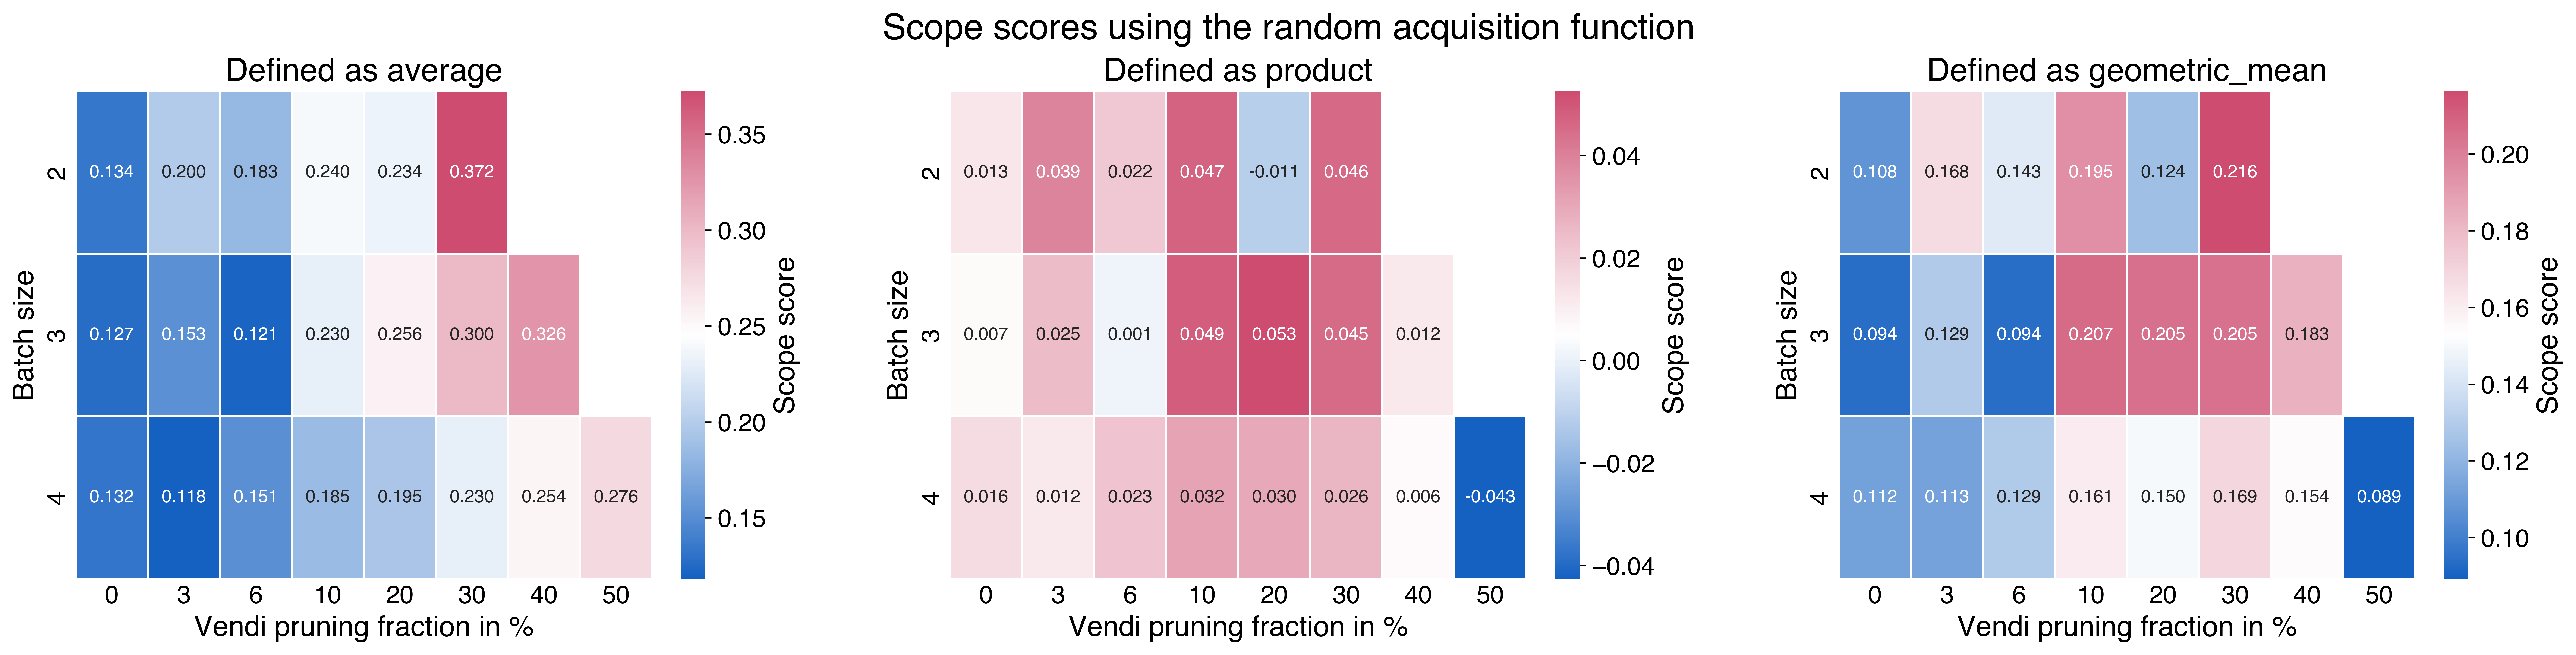

In [18]:
# Generating overviews using the same bounds for the other acqusition functions.
for acq_fct in ["Greedy","Explorative","Random"]:
    gen_scope_score_dist(vendi_bounds=(vendi_max,vendi_min),obj_bounds=(obj_max,obj_min),acq_fct=acq_fct.lower())

Under all definitions, the highest scope scores are obtained with the balanced and greedy acquisition function. This is consistent with the observations above that the greedy acquisition function provides the highest performance which is also still strong when sample pruning is conducted whereas the diversity of the selected samples increases strongly with added pruning.

The random and explorative acquisition functions only provide high scope scores in scenarios that are irrevelant (see text below).

Under the definition of the scope score as the average of performance and diversity, the explorative acquisition function provides high scope scores. This is because the Vendi scores are all very high with this acquisition function, albeit the performance is consistently very low. The averaging in the scope score calculation places no penalty on one of the metrics being low, resulting in the highly unbalanced explorative acquisition function performing very well. As we envisioned the scope score to capture a balance of performance and diversity, we decided against using this scope score definition. Of note, the explorative acquisition function provided low scope scores using the other definitions that require a more balanced performance-diversity tradeoff.

The relative results of the product and geometric mean definitions are very similar. In this case, the greedy acquisition function in the absence of sample pruning as well as generally the explorative one perform very poorly as they only perform well in one of the metrics. These scope score definitions therefore exhibit the desired focus on conditions in which both performance and diversity are maximized. As the product calculation mathematically puts a stronger penalty on poor values in one of the metrics, we decided to move forward with this scope score definition.

Based on these results, we only considered the balanced acquisition function and the greedy acquisition function for the algorithm optimization.

## Scope size dependence of the normalization bounds

As the scope score bounds will be dependent on the scope size, we decided to set them to fixed values obtained using a scope size of 40 samples. The idea is that this is a large scope by today's standards and comparing the scope obtained using a smaller scope to the best results achievable with such a large scope can validate the use of a smaller scope size.

### Get the bounds for a scope size of 40

Upper Vendi score bounds and low average rate bounds using the explorative acquisition function with maximum pruning:

In [19]:
# # most extreme vendi pruning for a reaction space of 2055 and scope of 40 samples for the different batch sizes
# extreme_pruning_40 = {1: 12, 2: 24, 3: 35, 4: 44}
# # Run the scopes
# for batch in extreme_pruning_40:
#     Benchmark().collect_data(
#         filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",  
#         name_results = f"./Results_Data/Scope_Score_Definition/40explorative_max/40explorative_max_b{batch}", objectives=['rate'], 
#         budget = 40, batches= [batch], Vendi_pruning_fractions = [extreme_pruning_40[batch]], seeds = 20, 
#         acquisition_function_mode= "explorative", pruning_metric= "vendi_batch", init_sampling_method="random")

In [20]:
# Get the data
vendi_explore_max_40 = []
for batch in [1,2,3,4]:
    df_explore_max_40 = Benchmark().heatmap_plot(type_results="vendi",
                                                 name_results=f"./Results_Data/Scope_Score_Definition/40explorative_max/40explorative_max_b{batch}",
                                                 budget=40,show_plot=False)
    vendi_explore_max_40.append(df_explore_max_40.max().max())  # recording the highest Vendi score for this scope
vendi_max40 = max(vendi_explore_max_40)
obj_explore_max_40 = []
for batch in [1,2,3,4]:
    df_explore_max_40 = Benchmark().heatmap_plot(type_results="objective",
                                                 name_results=f"./Results_Data/Scope_Score_Definition/40explorative_max/40explorative_max_b{batch}",
                                                 budget=40,show_plot=False)
    obj_explore_max_40.append(df_explore_max_40.min().min())  # recording the lowest average objective for this scope
obj_min40 = min(obj_explore_max_40)
print(f"Upper Vendi score bounds for a scope of size 40: {round(vendi_max40,3)}.")
print(f"Lower average objective bounds for a scope of size 40: {round(obj_min40,3)}.")

Upper Vendi score bounds for a scope of size 40: 6.314.
Lower average objective bounds for a scope of size 40: 1.175.


Lower Vendi score bounds and uppper average rate bounds using the greedy acquisition function without pruning:

In [21]:
# Benchmark().collect_data(
#     filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",  
#     name_results = f"./Results_Data/Scope_Score_Definition/40greedy", objectives=['rate'], 
#     budget = 40, batches= [1,2,3,4], Vendi_pruning_fractions = [0], seeds = 20, 
#     acquisition_function_mode= "greedy", pruning_metric= "vendi_batch", init_sampling_method="random")

In [22]:
# Get the data
df_greedy_40_vendi = Benchmark().heatmap_plot(type_results="vendi",name_results=f"./Results_Data/Scope_Score_Definition/40greedy",
                                              budget=40,show_plot=False)
vendi_min40 = df_greedy_40_vendi.min().min()
df_greedy_40_obj = Benchmark().heatmap_plot(type_results="objective",name_results=f"./Results_Data/Scope_Score_Definition/40greedy",
                                            budget=40,show_plot=False)
obj_max40 = df_greedy_40_obj.max().max()
print(f"Upper average objective  bounds for a scope of size 40: {round(obj_max40,3)}.")
print(f"Lower Vendi score bounds for a scope of size 40: {round(vendi_min40,3)}.")

Upper average objective  bounds for a scope of size 40: 1.985.
Lower Vendi score bounds for a scope of size 40: 2.167.


In [23]:
df_bounds = pd.DataFrame([[30,obj_min,obj_max,vendi_min,vendi_max],[40,obj_min40,obj_max40,vendi_min40,vendi_max40]],
                         columns=["Scope size","Obj_min","Obj_max","Vendi_min","Vendi_max"])
df_bounds.set_index("Scope size")

Obj_min   Obj_max  Vendi_min  Vendi_max
Scope size                                          
30          1.103525  1.896920   2.088019   6.219918
40          1.174966  1.984558   2.166708   6.313570

The bounds at scope sizes 30 and 40 are very similar.

We can now check if the choice to use normalization bounds obtained for 30 or 40 samples changes the scope score results.

Greedy acquisition function using bounds from scope size 30


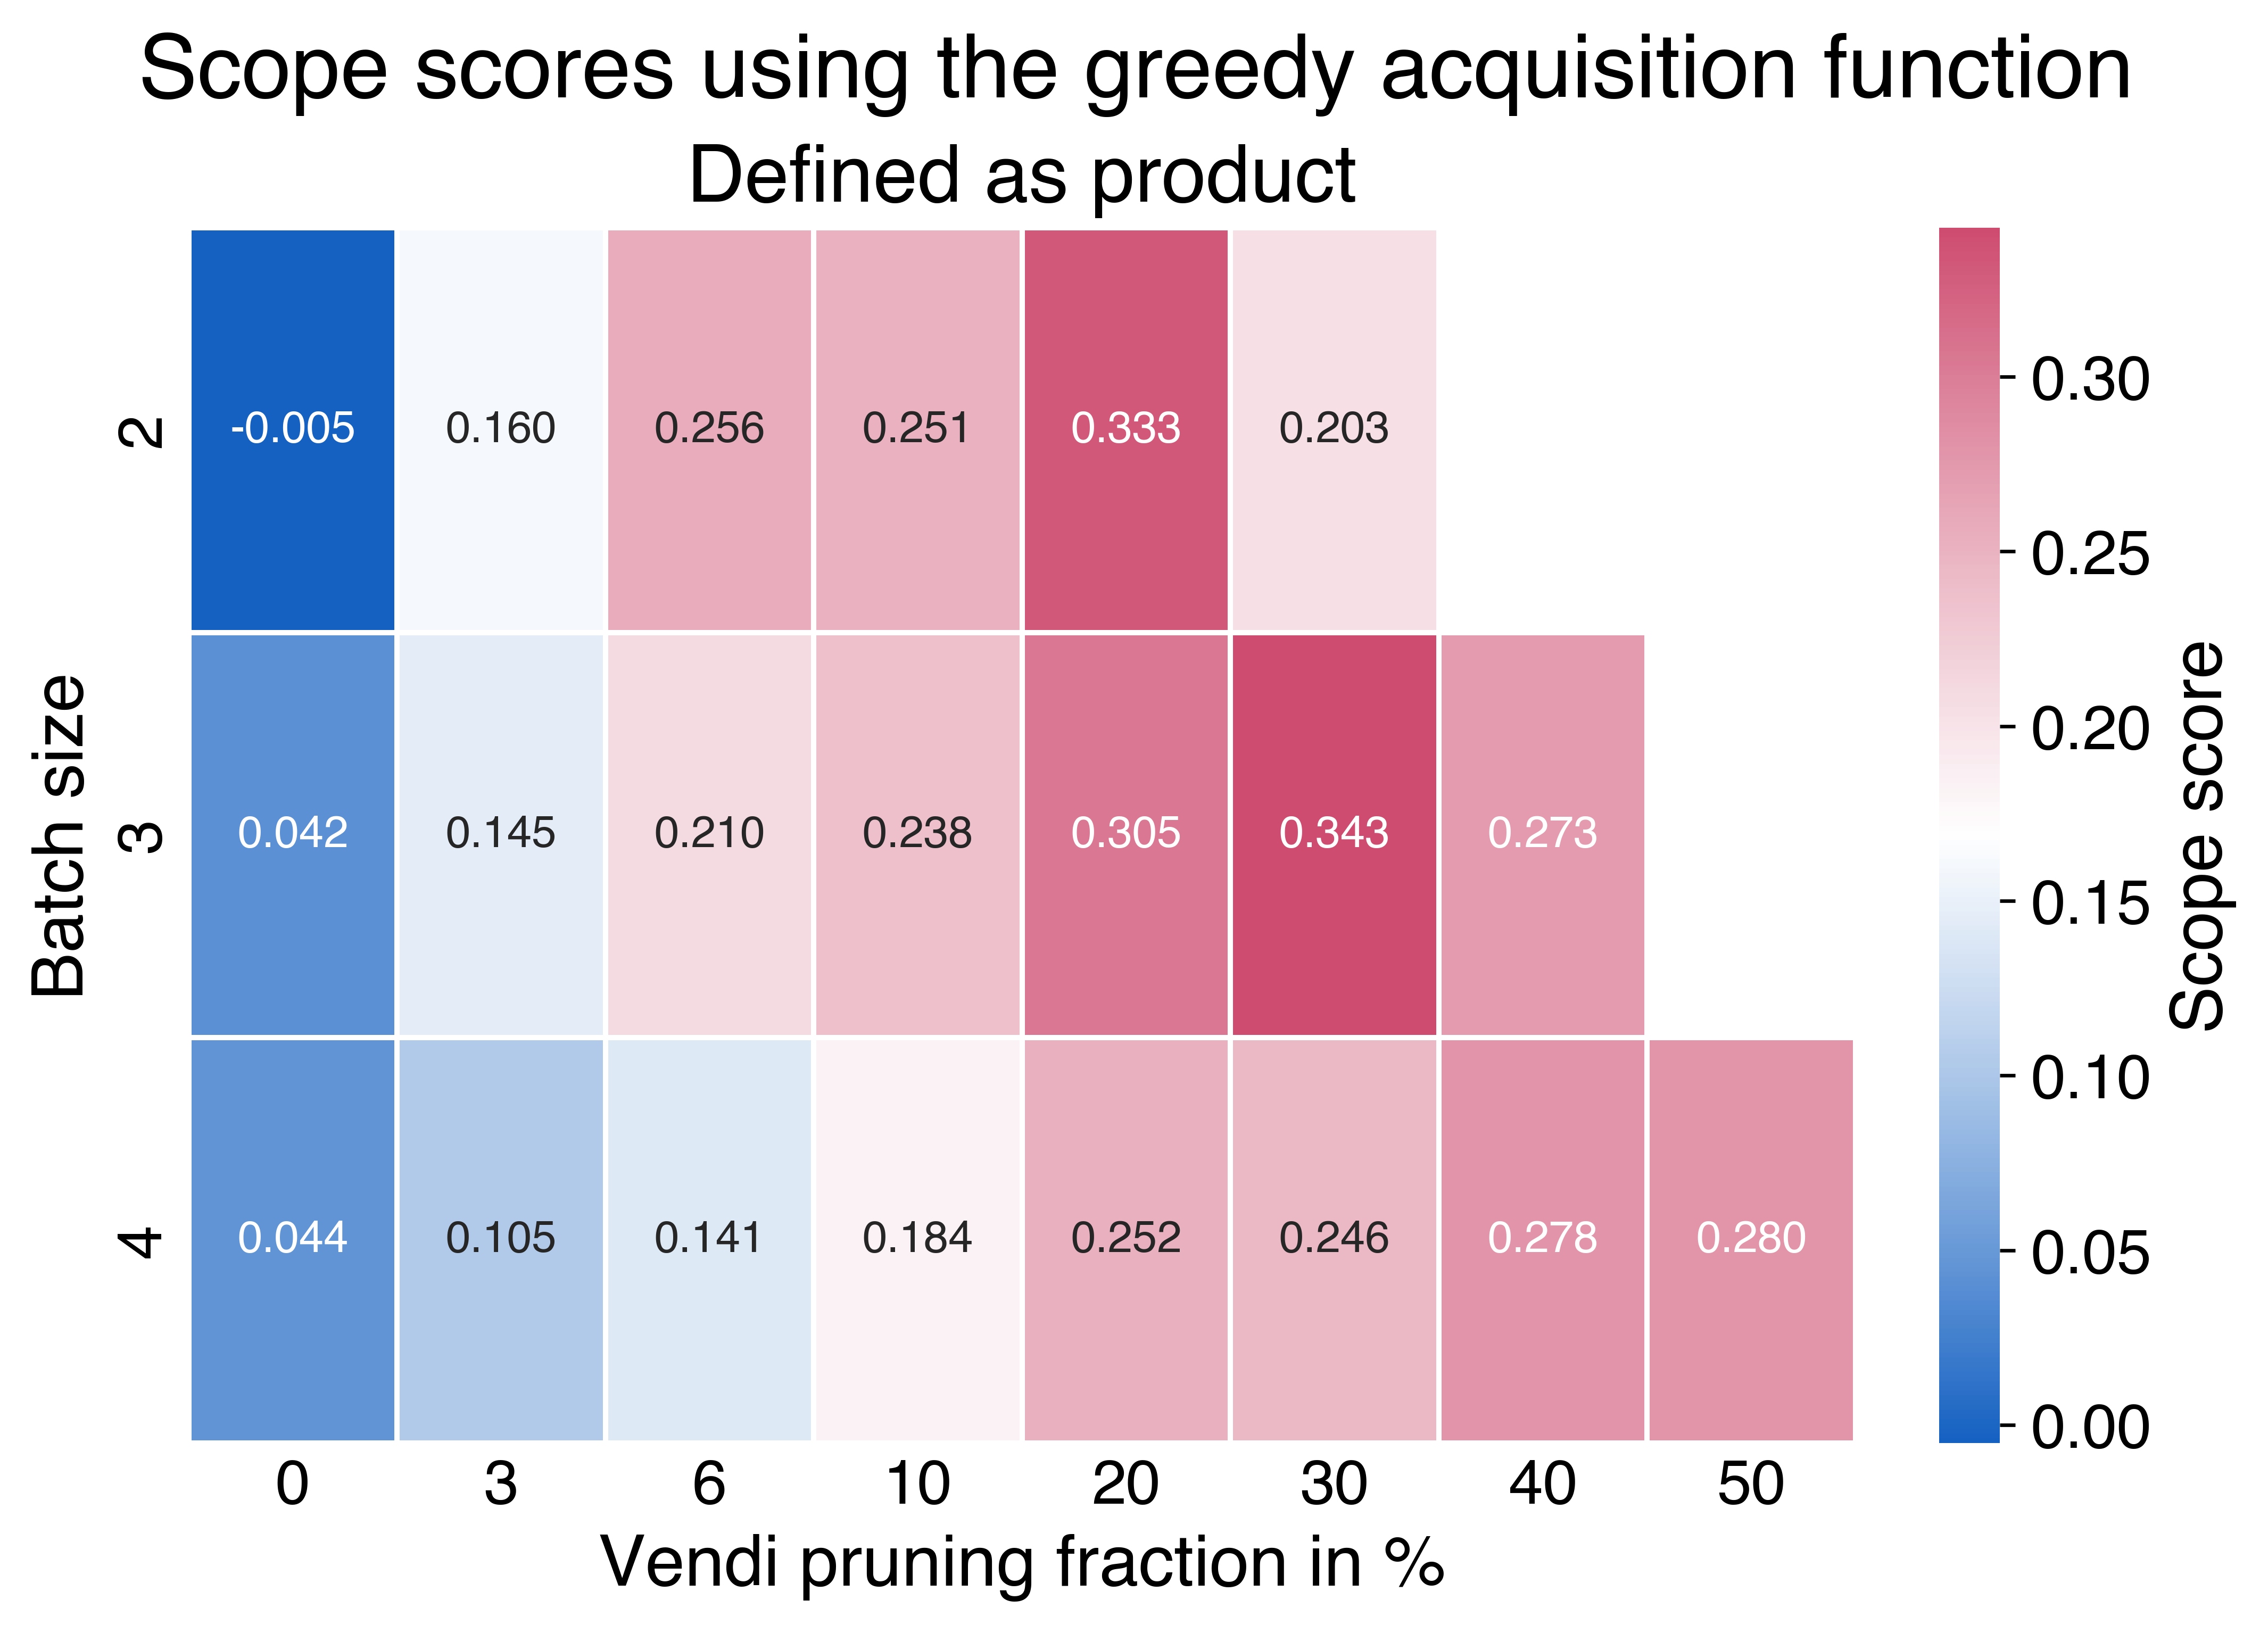

Greedy acquisition function using bounds from scope size 40


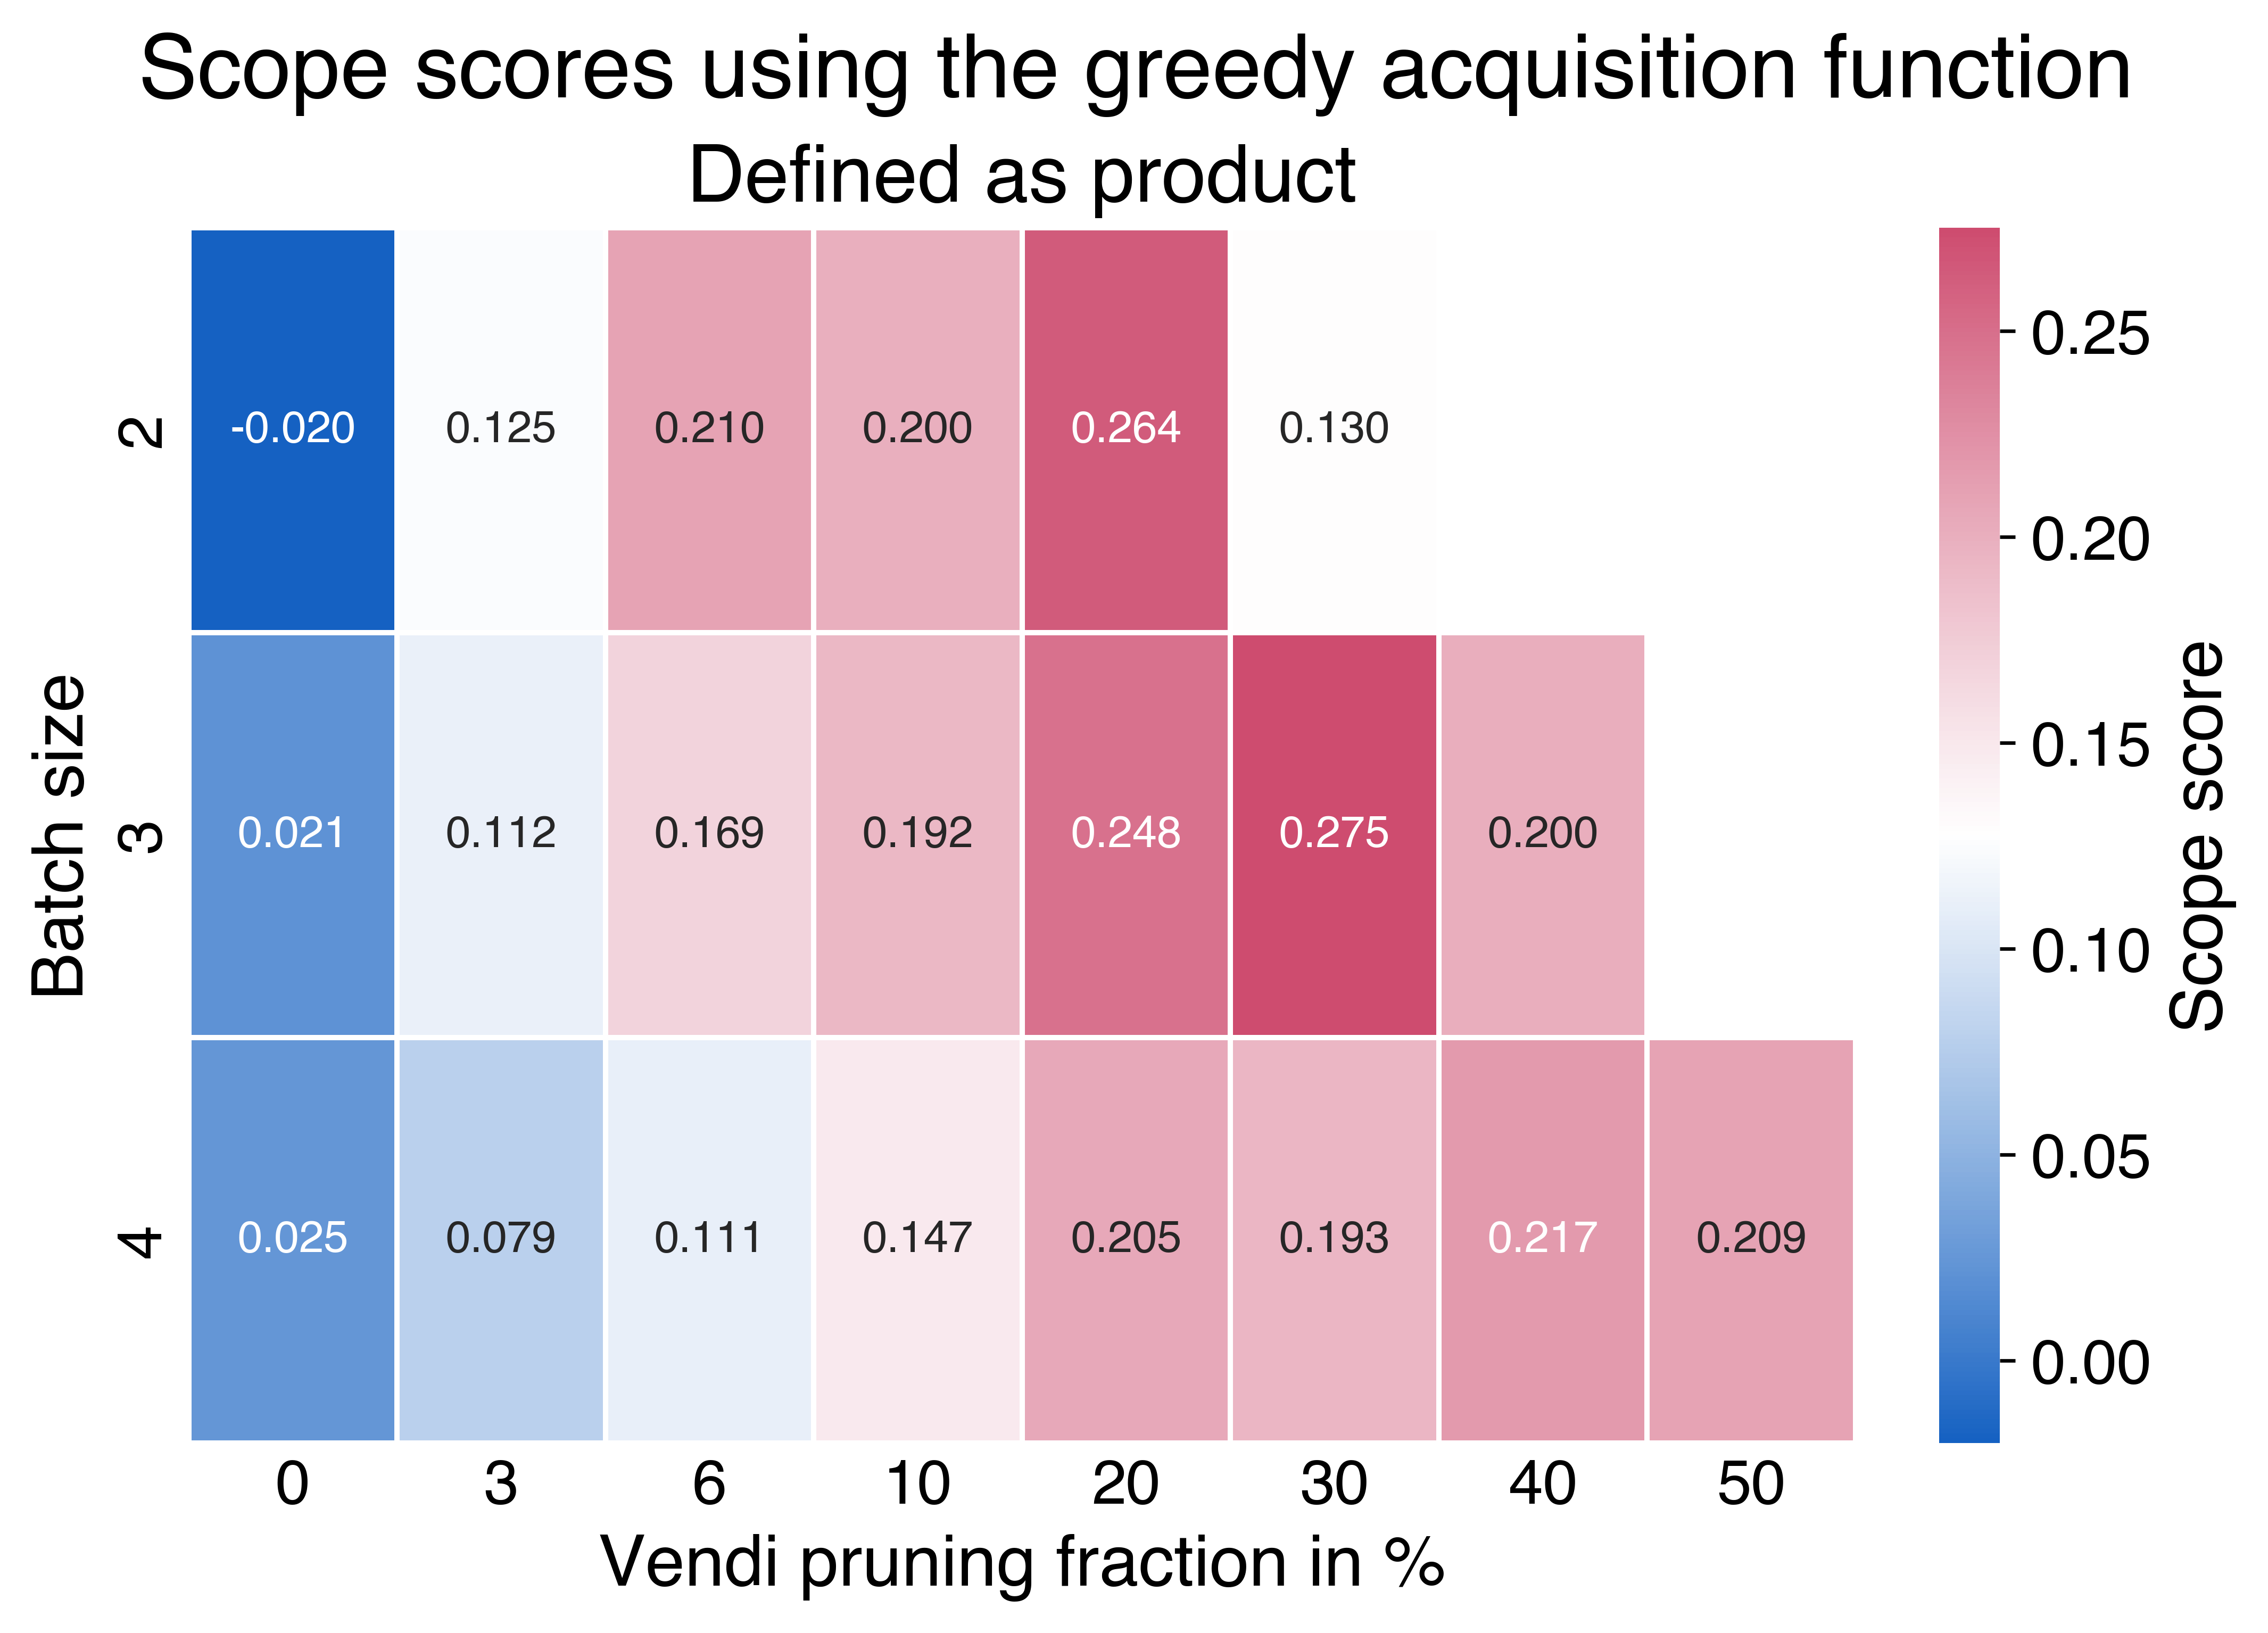

Balanced acquisition function using bounds from scope size 30


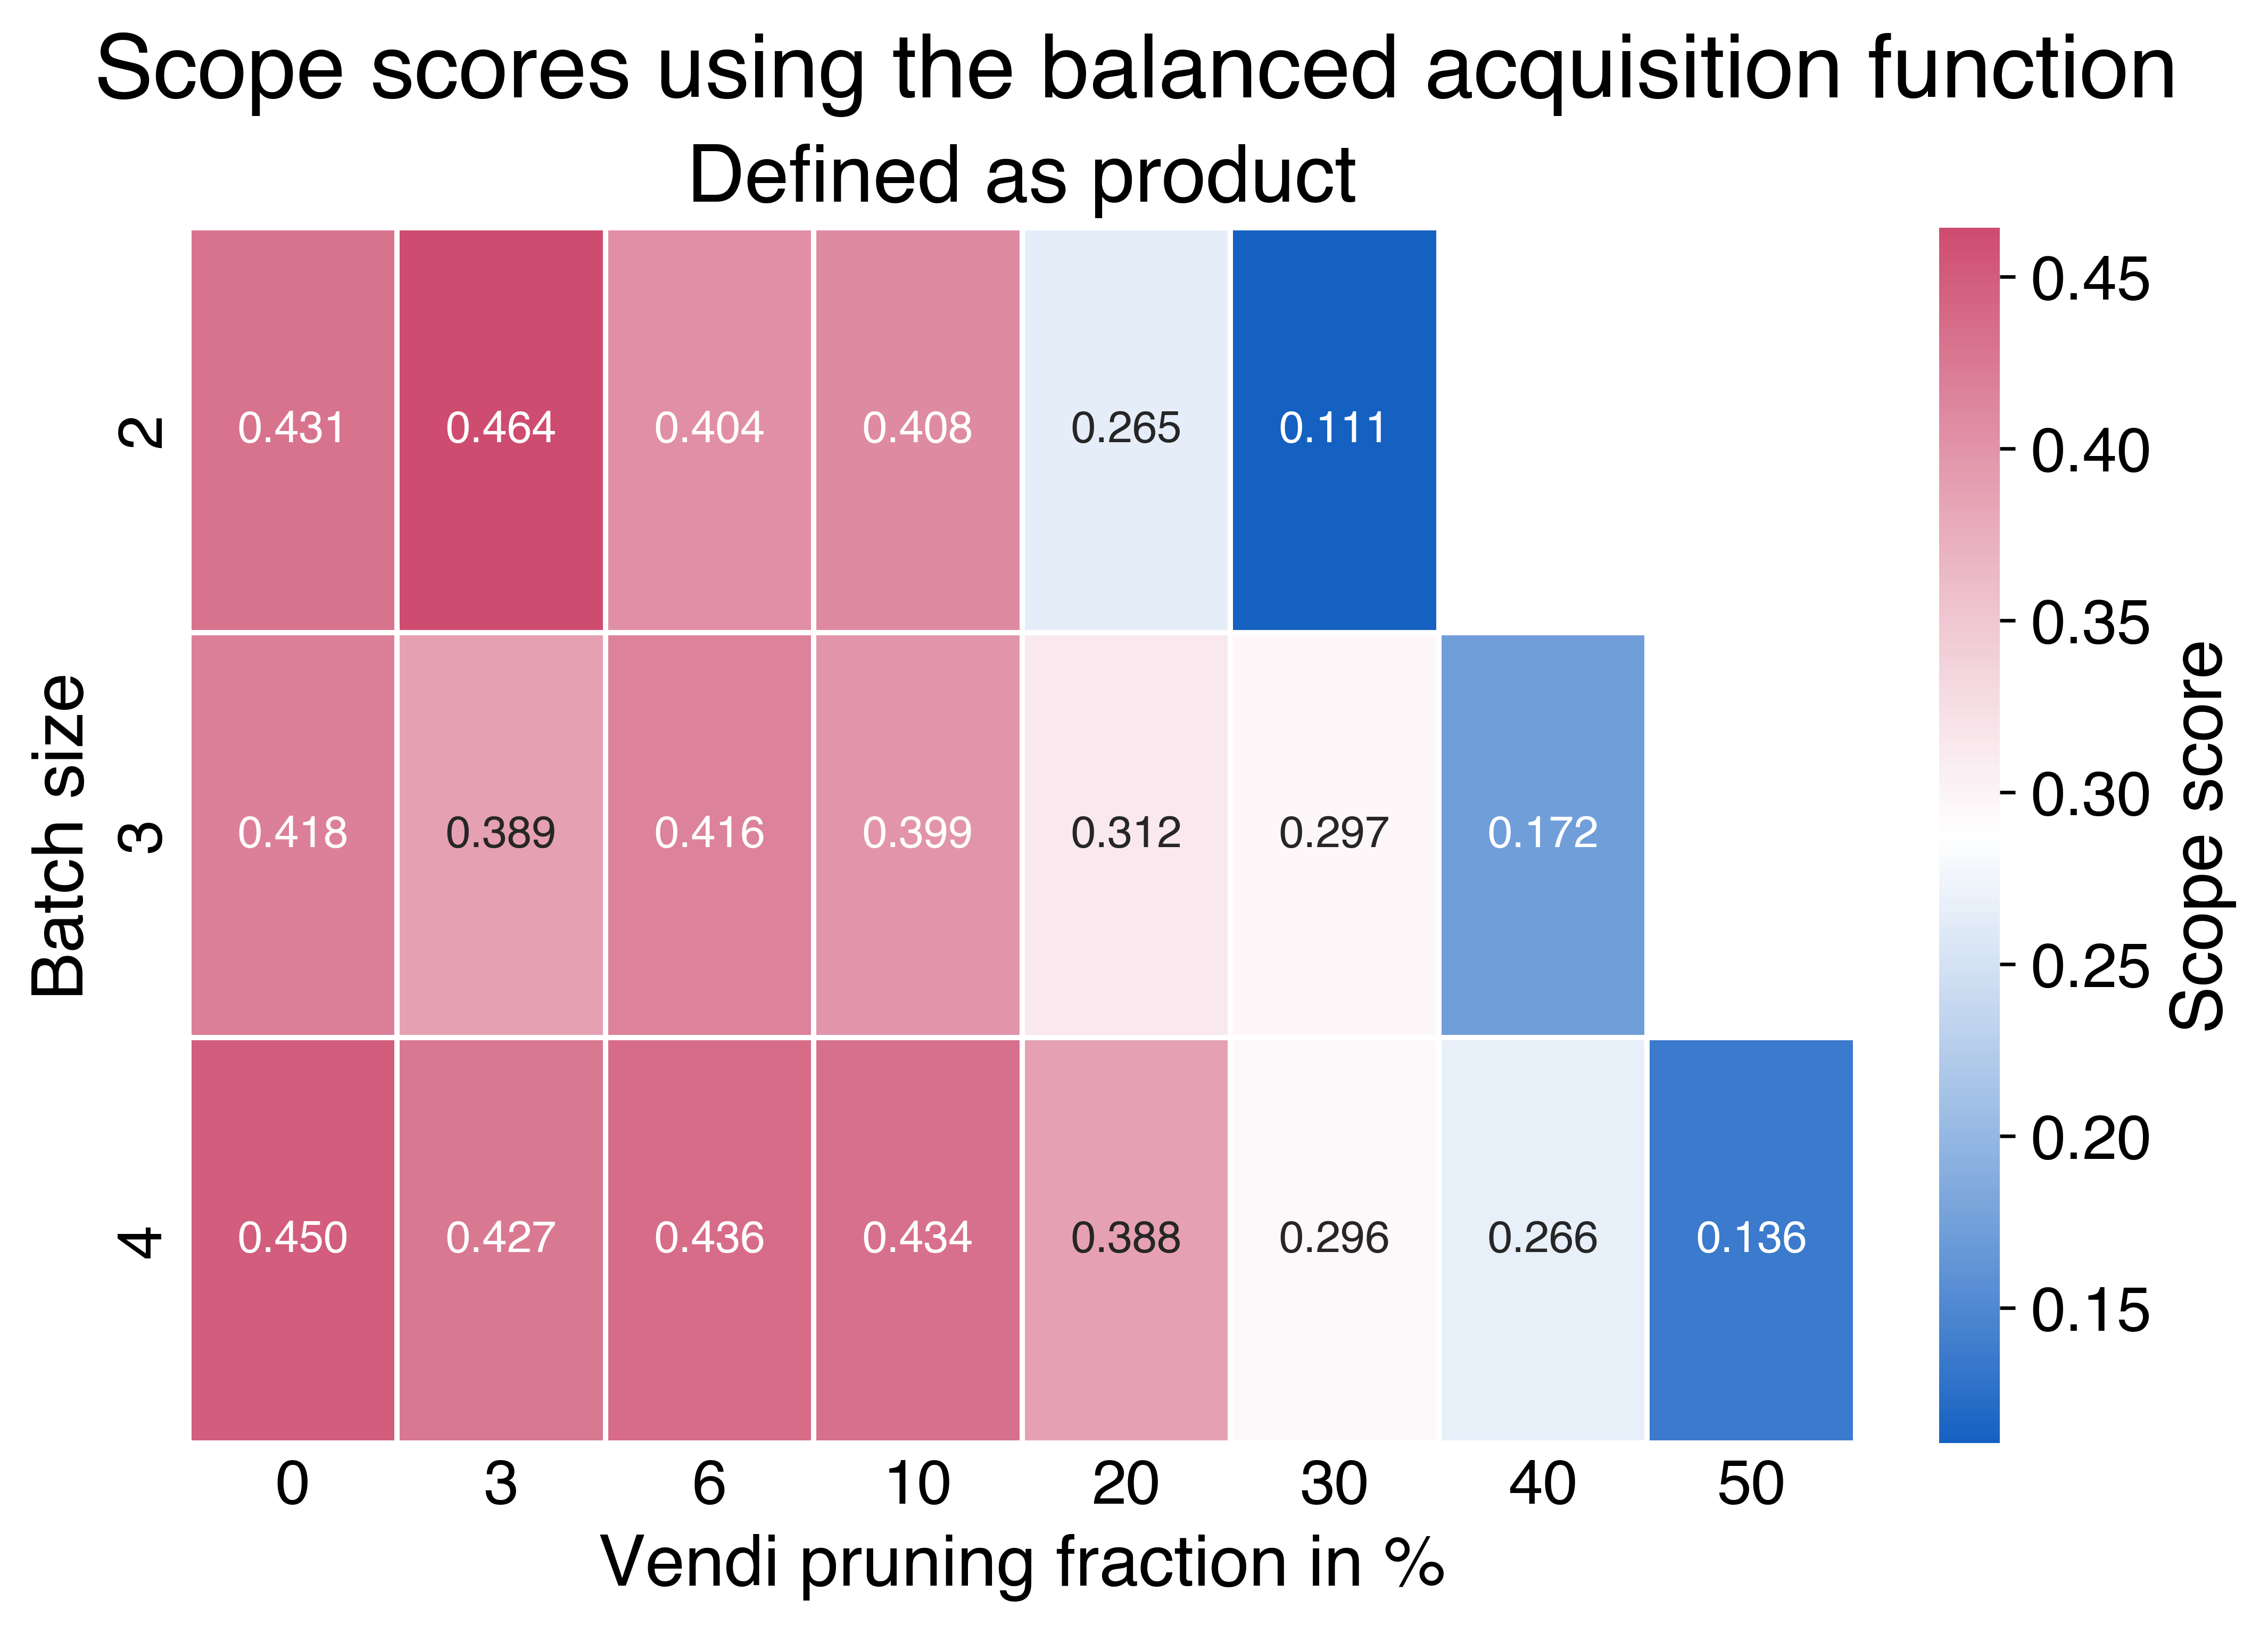

Balanced acquisition function using bounds from scope size 40


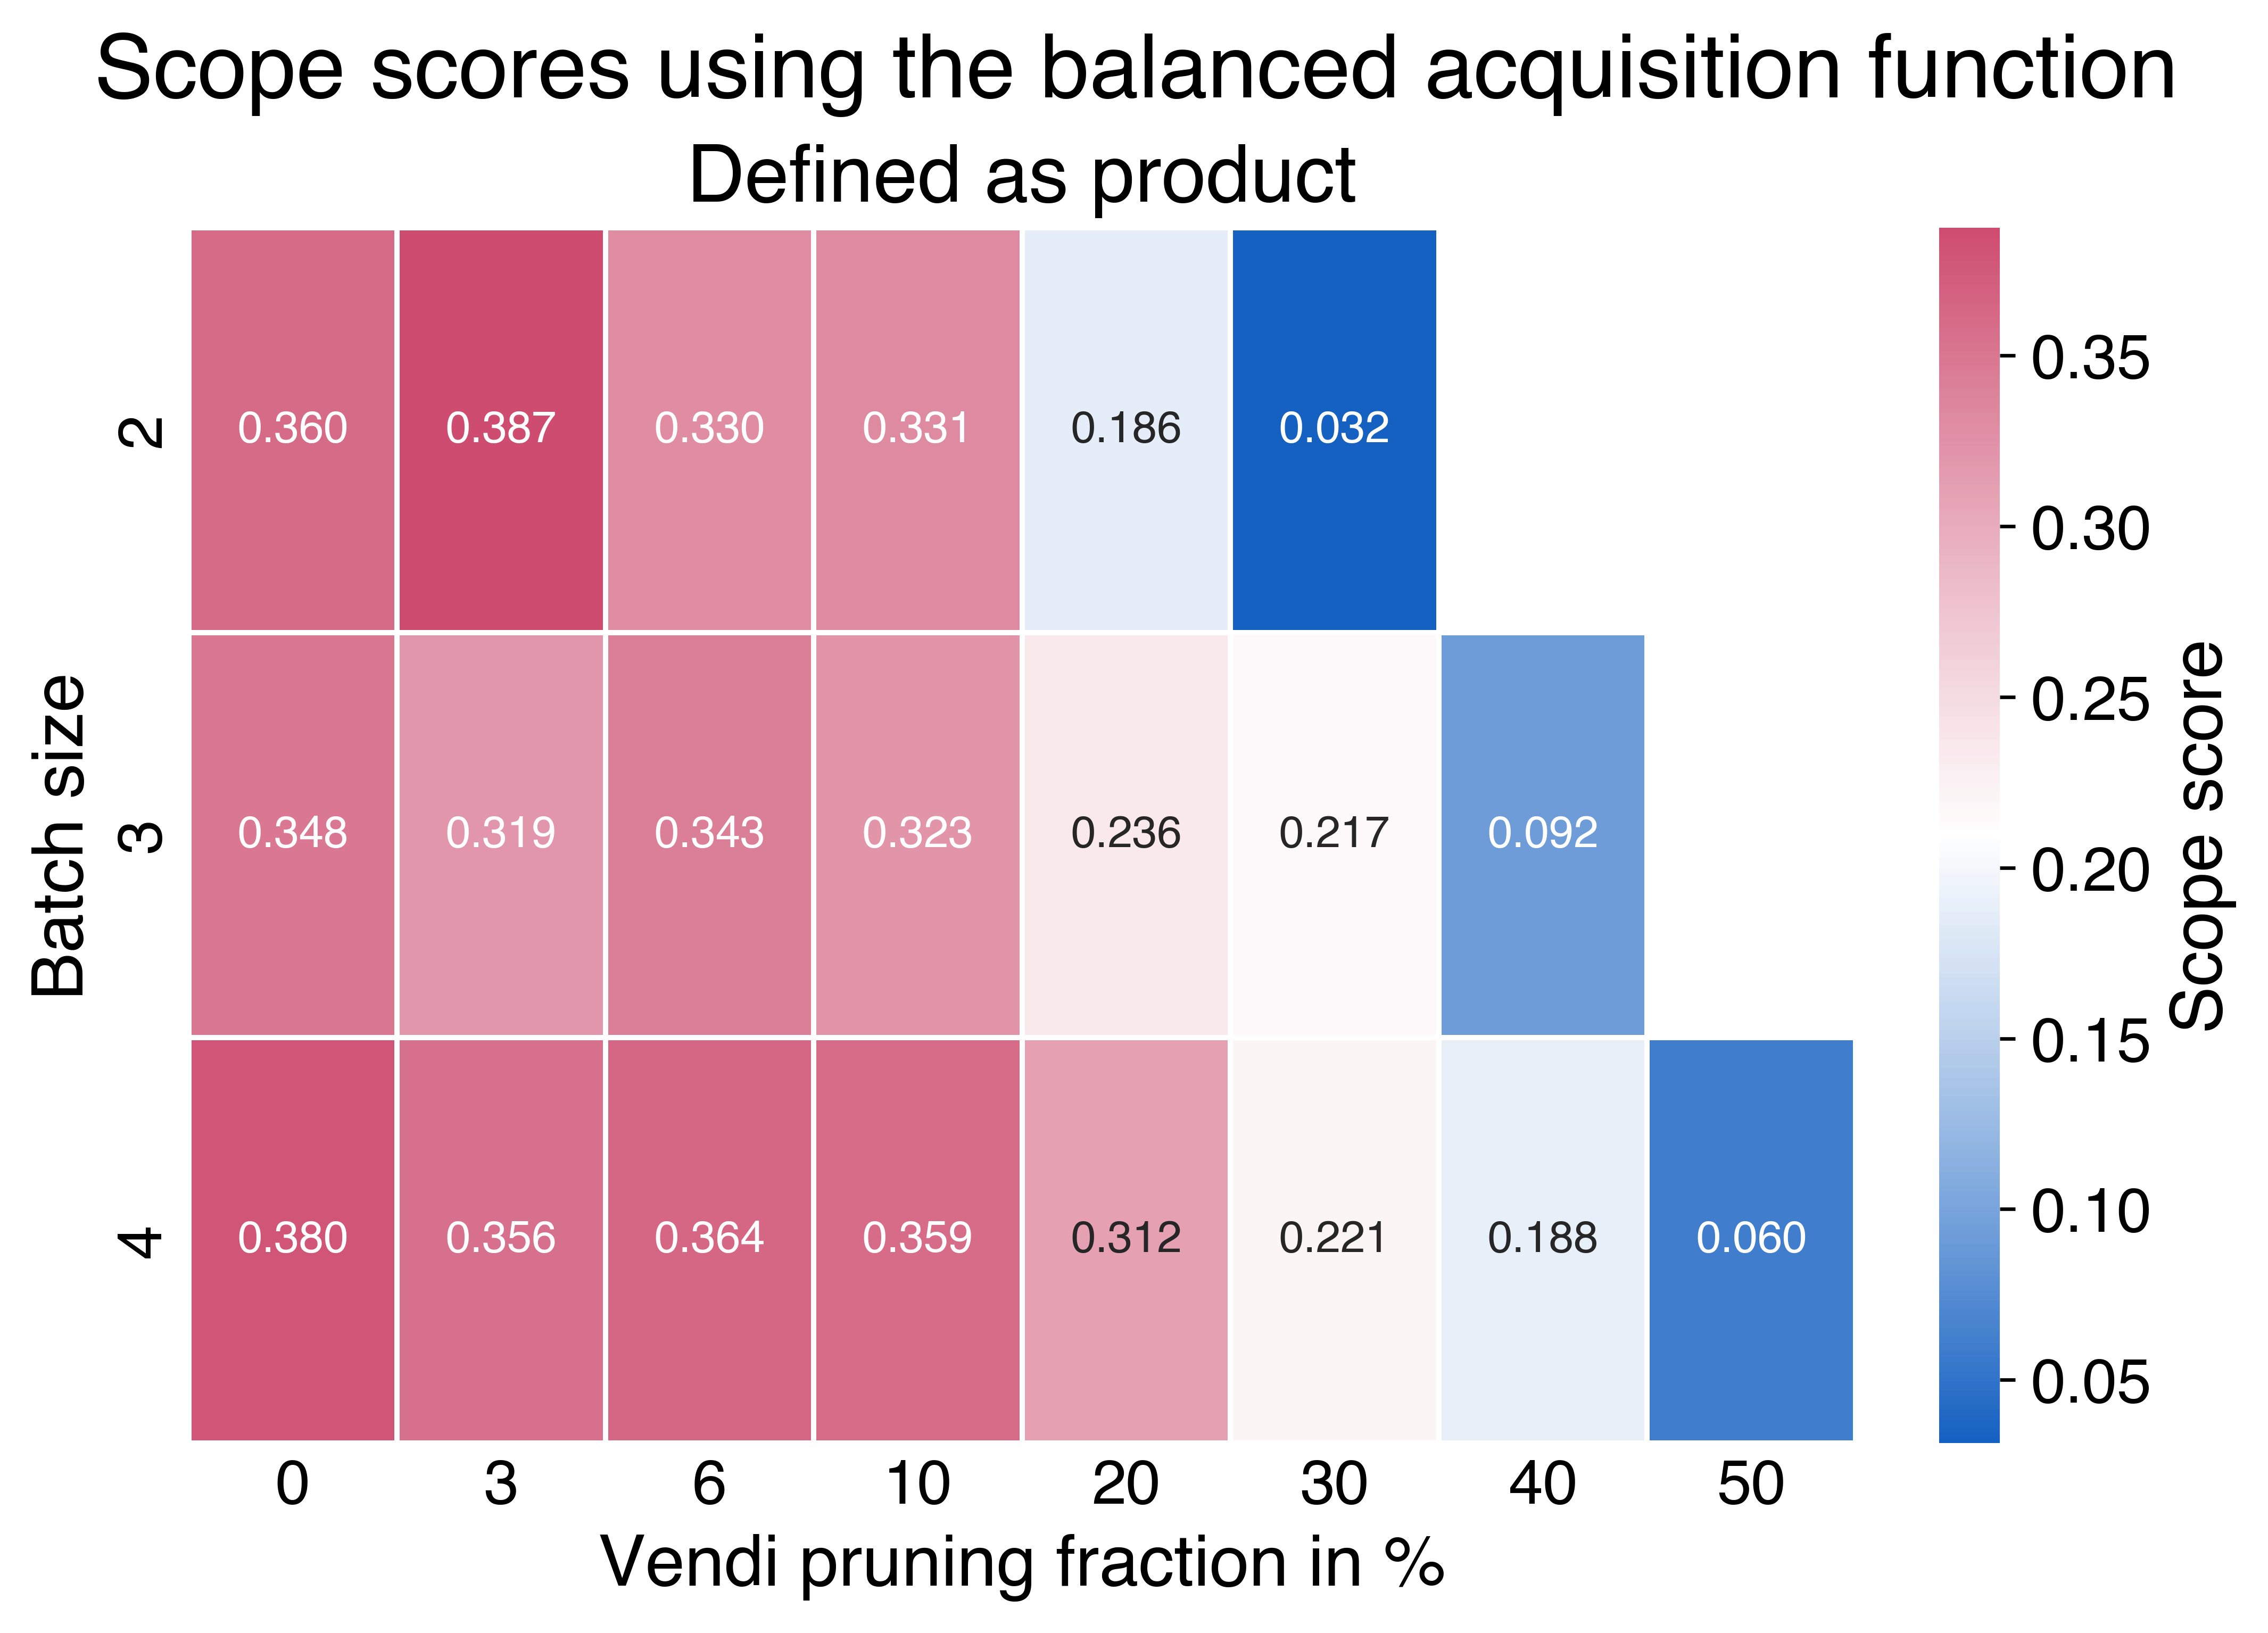

In [24]:
for acq_fct in ["Greedy","Balanced"]:
    for bounds in [30,40]:
        print(f"{acq_fct} acquisition function using bounds from scope size {bounds}")
        if bounds == 30:
            gen_scope_score_dist(vendi_bounds=(vendi_max,vendi_min),
                                 obj_bounds=(obj_max,obj_min),
                                 acq_fct=acq_fct.lower(), only_prod=True, figsize=(7,5))
        elif bounds == 40:
            gen_scope_score_dist(vendi_bounds=(vendi_max40,vendi_min40),
                                 obj_bounds=(obj_max40,obj_min40),
                                 acq_fct=acq_fct.lower(),
                                 only_prod=True, figsize = (7,5))
            

While the absolute values of the scope scores change, the relative trends remain almost identical, validating the approach of using metric bounds using a scope size of 40 samples.